Based on: https://medium.com/swlh/transformer-fine-tuning-for-sentiment-analysis-c000da034bb5

In [ ]:
!pip install pytorch-transformers
!pip install pytorch-ignite

     |████████████████████████████████| 184kB 4.7MB/s 
     |████████████████████████████████| 890kB 14.4MB/s 
     |████████████████████████████████| 1.1MB 26.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=8e4e2f0e6de88c2d1094549804401c811717cf4e5a50d8582c8a1960fd5f214a
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 112kB 4.5MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# !cp drive/'My Drive'/cs231n-project/train_captions_v2.pkl .
# !cp drive/'My Drive'/cs231n-project/val_captions_v2.pkl .
!cp drive/'My Drive'/cs231n-project/train_captions_pretrained_v1.pkl .
!cp drive/'My Drive'/cs231n-project/val_captions_pretrained_v1.pkl .

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pickle
with open("train_captions_pretrained_v1.pkl", "rb") as f:
    train_captions_obj = pickle.load(f)

In [ ]:
import pickle
with open("val_captions_pretrained_v1.pkl", "rb") as f:
    val_captions_obj = pickle.load(f)

In [ ]:
val_captions_obj["val_captions"][0][0]

[{'caption': 'a group of people sitting around a table with laptops .',
  'log_prob': -8.27091265593244},
 {'caption': 'a group of people sitting at a table with laptops .',
  'log_prob': -8.779468823420707},
 {'caption': 'a group of people standing around a table with a laptop .',
  'log_prob': -9.77529027415948}]

In [ ]:
import pandas as pd

train_captions = []
for tc in train_captions_obj["train_captions"]:
    # For each video
    sentences = []
    for t in tc:
        # For each frame, find the best caption (caption with the max log prob)
        best_caption = ""
        best_log_prob = -100

        for candidate in t:
            if candidate["log_prob"] > best_log_prob:
                best_log_prob = candidate["log_prob"]
                best_caption = candidate["caption"]

        best_caption = best_caption.replace(" .", "")
        sentences.append(best_caption)
        break
    train_captions.append("".join(sentences))
df_train = pd.DataFrame(list(zip(train_captions_obj["train_categories"], train_captions, train_captions_obj["train_videos"])), columns =['label', 'text', 'vid_name']) 


val_captions = []
for tc in val_captions_obj["val_captions"]:
    # For each video
    sentences = []
    for t in tc:
        # For each frame, find the best caption (caption with the max log prob)
        best_caption = ""
        best_log_prob = -100

        for candidate in t:
            if candidate["log_prob"] > best_log_prob:
                best_log_prob = candidate["log_prob"]
                best_caption = candidate["caption"]

        best_caption = best_caption.replace(" .", "")
        sentences.append(best_caption)
        break
    val_captions.append("".join(sentences))
df_val = pd.DataFrame(list(zip(val_captions_obj["val_categories"], val_captions, val_captions_obj["val_videos"])), columns =['label', 'text', 'vid_name']) 


In [ ]:
df_train.head(100)

,label,text,vid_name
0,2,a man and a woman sitting at a table,57_4
1,2,a group of people cutting a cake together,286_6
2,2,a group of people sitting around a table,276_3
3,2,a couple of women standing next to each other,61_10
4,2,a group of people sitting around a table eatin...,64_11
...,...,...,...
95,2,a man and a woman standing next to each other,168_4
96,2,a group of people standing next to each other,324_37
97,2,a group of people standing around a table with...,61_16
98,2,a group of people standing next to each other,286_4


In [ ]:
import sys
import os
import logging
from tqdm import tqdm_notebook as tqdm

logger = logging.getLogger()

# text and label column names
TEXT_COL = "text"
LABEL_COL = "label"

# path to data 
DATA_DIR = os.path.abspath('./data')


In [ ]:
# list of labels
labels = list(set(df_train[LABEL_COL].tolist()))

# labels to integers mapping
label2int = {label: i for i, label in enumerate(labels)}

In [ ]:
label2int

{'1': 2, '2': 0, '3': 1}

In [ ]:
import torch
from torch.utils.data import TensorDataset, random_split, DataLoader
import numpy as np
import warnings
from tqdm import tqdm_notebook as tqdm
from typing import List, Tuple

NUM_MAX_POSITIONS = 256
BATCH_SIZE = 32

class TextProcessor:
    
    # special tokens for classification and padding
    CLS = '[CLS]'
    PAD = '[PAD]'
    
    def __init__(self, tokenizer, label2id: dict, num_max_positions:int=512):
        self.tokenizer=tokenizer
        self.label2id = label2id
        self.num_labels = len(label2id)
        self.num_max_positions = num_max_positions
        
    
    def process_example(self, example: Tuple[str, str]):
        "Convert text (example[0]) to sequence of IDs and label (example[1] to integer"
        assert len(example) == 2
        label, text = example[0], example[1]
        assert isinstance(text, str)
        tokens = self.tokenizer.tokenize(text)

        # truncate if too long
        if len(tokens) >= self.num_max_positions:
            tokens = tokens[:self.num_max_positions-1] 
            ids =  self.tokenizer.convert_tokens_to_ids(tokens) + [self.tokenizer.vocab[self.CLS]]
        # pad if too short
        else:
            pad = [self.tokenizer.vocab[self.PAD]] * (self.num_max_positions-len(tokens)-1)
            ids =  self.tokenizer.convert_tokens_to_ids(tokens) + [self.tokenizer.vocab[self.CLS]] + pad
        
        return np.array(ids, dtype='int64'), self.label2id[label]
    
# download the 'bert-base-cased' tokenizer
from pytorch_transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

# initialize a TextProcessor
processor = TextProcessor(tokenizer, label2int, num_max_positions=NUM_MAX_POSITIONS)

In [ ]:
from collections import namedtuple
import torch

LOG_DIR = "./logs/"
CACHE_DIR = "./cache/"

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

FineTuningConfig = namedtuple('FineTuningConfig',
      field_names="num_classes, dropout, init_range, batch_size, lr, max_norm,"
                  "n_warmup, valid_pct, gradient_acc_steps, device, log_dir")

finetuning_config = FineTuningConfig(
                3, 0.05, 0.02, BATCH_SIZE, 6.5e-5, 1.0,
                10, 0.1, 2, device, LOG_DIR)

finetuning_config

FineTuningConfig(num_classes=3, dropout=0.05, init_range=0.02, batch_size=32, lr=6.5e-05, max_norm=1.0, n_warmup=10, valid_pct=0.1, gradient_acc_steps=2, device=device(type='cuda', index=0), log_dir='./logs/')

In [ ]:
from multiprocessing import cpu_count
from concurrent.futures import ProcessPoolExecutor
from itertools import repeat

num_cores = cpu_count()

def process_row(processor, row):
    return processor.process_example((row[1][LABEL_COL], row[1][TEXT_COL]))

def create_dataloader(df: pd.DataFrame,
                      processor: TextProcessor,
                      batch_size: int = 32,
                      shuffle: bool = True,
                      valid_pct: float = None,
                      text_col: str = "text",
                      label_col: str = "label"):
    "Process rows in `df` with `processor` and return a  DataLoader"

    with ProcessPoolExecutor(max_workers=num_cores) as executor:
        result = list(
            tqdm(executor.map(process_row,
                              repeat(processor),
                              df.iterrows(),
                              chunksize=len(df) // 10),
                 desc=f"Processing {len(df)} examples on {num_cores} cores",
                 total=len(df)))

    features = [r[0] for r in result]
    labels = [r[1] for r in result]

    dataset = TensorDataset(torch.tensor(features, dtype=torch.long),
                            torch.tensor(labels, dtype=torch.long))

    if valid_pct is not None:
        valid_size = int(valid_pct * len(df))
        train_size = len(df) - valid_size
        valid_dataset, train_dataset = random_split(dataset,
                                                    [valid_size, train_size])
        valid_loader = DataLoader(valid_dataset,
                                  batch_size=batch_size,
                                  shuffle=False)
        train_loader = DataLoader(train_dataset,
                                  batch_size=batch_size,
                                  shuffle=True)
        return train_loader, valid_loader

    data_loader = DataLoader(dataset,
                             batch_size=batch_size,
                             shuffle=shuffle)
    return data_loader

In [ ]:
train_dl = create_dataloader(df_train, processor, 
                             batch_size=finetuning_config.batch_size, 
                             valid_pct=None)

valid_dl = create_dataloader(df_val, processor, 
                             batch_size=finetuning_config.batch_size, 
                             valid_pct=None)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [ ]:
import torch.nn as nn

def get_num_params(model):
    mp = filter(lambda p: p.requires_grad, model.parameters())
    return sum(np.prod(p.size()) for p in mp)

class Transformer(nn.Module):
    "Adopted from https://github.com/huggingface/naacl_transfer_learning_tutorial"

    def __init__(self, embed_dim, hidden_dim, num_embeddings, num_max_positions, num_heads, num_layers, dropout, causal):
        super().__init__()
        self.causal = causal
        self.tokens_embeddings = nn.Embedding(num_embeddings, embed_dim)
        self.position_embeddings = nn.Embedding(num_max_positions, embed_dim)
        self.dropout = nn.Dropout(dropout)

        self.attentions, self.feed_forwards = nn.ModuleList(), nn.ModuleList()
        self.layer_norms_1, self.layer_norms_2 = nn.ModuleList(), nn.ModuleList()
        for _ in range(num_layers):
            self.attentions.append(nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout))
            self.feed_forwards.append(nn.Sequential(nn.Linear(embed_dim, hidden_dim),
                                                    nn.ReLU(),
                                                    nn.Linear(hidden_dim, embed_dim)))
            self.layer_norms_1.append(nn.LayerNorm(embed_dim, eps=1e-12))
            self.layer_norms_2.append(nn.LayerNorm(embed_dim, eps=1e-12))

    def forward(self, x, padding_mask=None):
        """ x has shape [seq length, batch], padding_mask has shape [batch, seq length] """
        positions = torch.arange(len(x), device=x.device).unsqueeze(-1)
        h = self.tokens_embeddings(x)
        h = h + self.position_embeddings(positions).expand_as(h)
        h = self.dropout(h)

        attn_mask = None
        if self.causal:
            attn_mask = torch.full((len(x), len(x)), -float('Inf'), device=h.device, dtype=h.dtype)
            attn_mask = torch.triu(attn_mask, diagonal=1)

        for layer_norm_1, attention, layer_norm_2, feed_forward in zip(self.layer_norms_1, self.attentions,
                                                                       self.layer_norms_2, self.feed_forwards):
            h = layer_norm_1(h)
            x, _ = attention(h, h, h, attn_mask=attn_mask, need_weights=False, key_padding_mask=padding_mask)
            x = self.dropout(x)
            h = x + h

            h = layer_norm_2(h)
            x = feed_forward(h)
            x = self.dropout(x)
            h = x + h
        return h


class TransformerWithClfHead(nn.Module):
    "Adopted from https://github.com/huggingface/naacl_transfer_learning_tutorial"
    def __init__(self, config, fine_tuning_config):
        super().__init__()
        self.config = fine_tuning_config
        self.transformer = Transformer(config.embed_dim, config.hidden_dim, config.num_embeddings,
                                       config.num_max_positions, config.num_heads, config.num_layers,
                                       fine_tuning_config.dropout, causal=not config.mlm)
        
        self.classification_head = nn.Linear(config.embed_dim, fine_tuning_config.num_classes)
        self.apply(self.init_weights)

    def init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding, nn.LayerNorm)):
            module.weight.data.normal_(mean=0.0, std=self.config.init_range)
        if isinstance(module, (nn.Linear, nn.LayerNorm)) and module.bias is not None:
            module.bias.data.zero_()

    def forward(self, x, clf_tokens_mask, clf_labels=None, padding_mask=None):
        hidden_states = self.transformer(x, padding_mask)

        clf_tokens_states = (hidden_states * clf_tokens_mask.unsqueeze(-1).float()).sum(dim=0)
        clf_logits = self.classification_head(clf_tokens_states)

        if clf_labels is not None:
            loss_fct = nn.CrossEntropyLoss(ignore_index=-1)
            loss = loss_fct(clf_logits.view(-1, clf_logits.size(-1)), clf_labels.view(-1))
            return clf_logits, loss
        return clf_logits

In [ ]:
from pytorch_transformers import cached_path

# download pre-trained model and config
state_dict = torch.load(cached_path("https://s3.amazonaws.com/models.huggingface.co/"
                                    "naacl-2019-tutorial/model_checkpoint.pth"), map_location='cpu')

config = torch.load(cached_path("https://s3.amazonaws.com/models.huggingface.co/"
                                        "naacl-2019-tutorial/model_training_args.bin"))

# init model: Transformer base + classifier head
model = TransformerWithClfHead(config=config, fine_tuning_config=finetuning_config).to(finetuning_config.device)

incompatible_keys = model.load_state_dict(state_dict, strict=False)
print(f"Parameters discarded from the pretrained model: {incompatible_keys.unexpected_keys}")
print(f"Parameters added in the model: {incompatible_keys.missing_keys}")

Parameters discarded from the pretrained model: ['lm_head.weight']
Parameters added in the model: ['classification_head.weight', 'classification_head.bias']


In [ ]:
NUM_EPOCHS = 10

In [ ]:
from ignite.engine import Engine, Events
from ignite.metrics import RunningAverage, Accuracy 
from ignite.handlers import ModelCheckpoint
from ignite.contrib.handlers import CosineAnnealingScheduler, PiecewiseLinear, create_lr_scheduler_with_warmup, ProgressBar
import torch.nn.functional as F
from pytorch_transformers.optimization import AdamW

# Bert optimizer
optimizer = AdamW(model.parameters(), lr=finetuning_config.lr, correct_bias=False) 

def update(engine, batch):
    "update function for training"
    model.train()
    inputs, labels = (t.to(finetuning_config.device) for t in batch)
    inputs = inputs.transpose(0, 1).contiguous() # [S, B]
    _, loss = model(inputs, 
                    clf_tokens_mask = (inputs == tokenizer.vocab[processor.CLS]), 
                    clf_labels=labels)
    loss = loss / finetuning_config.gradient_acc_steps
    loss.backward()
    
    torch.nn.utils.clip_grad_norm_(model.parameters(), finetuning_config.max_norm)
    if engine.state.iteration % finetuning_config.gradient_acc_steps == 0:
        optimizer.step()
        optimizer.zero_grad()
    return loss.item()

def inference(engine, batch):
    "update function for evaluation"
    model.eval()
    with torch.no_grad():
        batch, labels = (t.to(finetuning_config.device) for t in batch)
        inputs = batch.transpose(0, 1).contiguous()
        logits = model(inputs,
                       clf_tokens_mask = (inputs == tokenizer.vocab[processor.CLS]),
                       padding_mask = (batch == tokenizer.vocab[processor.PAD]))
    return logits, labels

def predict(model, tokenizer, int2label, input="test"):
    "predict `input` with `model`"
    tok = tokenizer.tokenize(input)
    ids = tokenizer.convert_tokens_to_ids(tok) + [tokenizer.vocab['[CLS]']]
    tensor = torch.tensor(ids, dtype=torch.long)
    tensor = tensor.to(device)
    tensor = tensor.reshape(1, -1)
    tensor_in = tensor.transpose(0, 1).contiguous() # [S, 1]
    logits = model(tensor_in,
                   clf_tokens_mask = (tensor_in == tokenizer.vocab['[CLS]']),
                   padding_mask = (tensor == tokenizer.vocab['[PAD]']))
    val, _ = torch.max(logits, 0)
    val = F.softmax(val, dim=0).detach().cpu().numpy()    
    return {int2label[val.argmax()]: val.max(),
            int2label[val.argmin()]: val.min()}

trainer = Engine(update)
evaluator = Engine(inference)

# add metric to evaluator 
Accuracy().attach(evaluator, "accuracy")

# add evaluator to trainer: eval on valid set after each epoch
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    evaluator.run(train_dl)
    print(f"validation epoch: {engine.state.epoch} train acc: {100*evaluator.state.metrics['accuracy']}")
    evaluator.run(valid_dl)
    print(f"validation epoch: {engine.state.epoch} val acc: {100*evaluator.state.metrics['accuracy']}")

# lr schedule: linearly warm-up to lr and then to zero
scheduler = PiecewiseLinear(optimizer, 'lr', [(0, 0.0), (finetuning_config.n_warmup, finetuning_config.lr),
                                              (len(train_dl)*NUM_EPOCHS, 0.0)])
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)


# add progressbar with loss
RunningAverage(output_transform=lambda x: x).attach(trainer, "loss")
ProgressBar(persist=True).attach(trainer, metric_names=['loss'])

# save checkpoints and finetuning config
checkpoint_handler = ModelCheckpoint(finetuning_config.log_dir, 'sentiment-transformer', 
                                     n_saved=None, require_empty=False)
trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpoint_handler, {'sentiment-transformer': model})

int2label = {i:label for label,i in label2int.items()}

# save metadata
torch.save({
    "config": config,
    "config_ft": finetuning_config,
    "int2label": int2label
}, os.path.join(finetuning_config.log_dir, "sentiment-transformer.metadata.bin"))

In [ ]:
# fit the model on train_dl
trainer.run(train_dl, max_epochs=NUM_EPOCHS)

validation epoch: 1 train acc: 49.3423524990605
validation epoch: 1 val acc: 41.38381201044387



validation epoch: 2 train acc: 50.84554678692221
validation epoch: 2 val acc: 46.344647519582246



validation epoch: 3 train acc: 53.10033821871477
validation epoch: 3 val acc: 46.47519582245431



validation epoch: 4 train acc: 55.956407365652005
validation epoch: 4 val acc: 49.47780678851175



validation epoch: 5 train acc: 57.19654265313792
validation epoch: 5 val acc: 49.21671018276763



validation epoch: 6 train acc: 57.68508079669298
validation epoch: 6 val acc: 49.73890339425587



validation epoch: 7 train acc: 58.436677940623824
validation epoch: 7 val acc: 48.30287206266319



validation epoch: 8 train acc: 58.47425779782037
validation epoch: 8 val acc: 48.825065274151434



validation epoch: 9 train acc: 59.07553551296505
validation epoch: 9 val acc: 49.47780678851175



validation epoch: 10 train acc: 59.15069522735814
validation epoch: 10 val acc: 49.21671018276763



State:
	iteration: 840
	epoch: 10
	epoch_length: 84
	max_epochs: 10
	output: 0.23070499300956726
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: 12

In [ ]:
!ls -lht logs

total 2.1G
-rw-r--r-- 1 root root 1.1K Jun 19 04:10 sentiment-transformer.metadata.bin
-rw------- 1 root root 193M Jun 19 03:45 sentiment-transformer_sentiment-transformer_840.pth
-rw------- 1 root root 193M Jun 19 03:44 sentiment-transformer_sentiment-transformer_756.pth
-rw------- 1 root root 193M Jun 19 03:43 sentiment-transformer_sentiment-transformer_672.pth
-rw------- 1 root root 193M Jun 19 03:42 sentiment-transformer_sentiment-transformer_588.pth
-rw------- 1 root root 193M Jun 19 03:41 sentiment-transformer_sentiment-transformer_504.pth
-rw------- 1 root root 193M Jun 19 03:40 sentiment-transformer_sentiment-transformer_420.pth
-rw------- 1 root root 193M Jun 19 03:39 sentiment-transformer_sentiment-transformer_336.pth
-rw------- 1 root root 193M Jun 19 03:38 sentiment-transformer_sentiment-transformer_252.pth
-rw------- 1 root root 193M Jun 19 03:37 sentiment-transformer_sentiment-transformer_168.pth
-rw------- 1 root root 193M Jun 19 03:36 sentiment-transformer_sentiment-tra

In [ ]:

# save metadata
torch.save({
    "config": config,
    "config_ft": finetuning_config,
    "int2label": int2label
}, os.path.join(finetuning_config.log_dir, "sentiment-transformer.metadata.bin"))

In [ ]:
print(model)

TransformerWithClfHead(
  (transformer): Transformer(
    (tokens_embeddings): Embedding(28996, 410)
    (position_embeddings): Embedding(256, 410)
    (dropout): Dropout(p=0.05, inplace=False)
    (attentions): ModuleList(
      (0): MultiheadAttention(
        (out_proj): Linear(in_features=410, out_features=410, bias=True)
      )
      (1): MultiheadAttention(
        (out_proj): Linear(in_features=410, out_features=410, bias=True)
      )
      (2): MultiheadAttention(
        (out_proj): Linear(in_features=410, out_features=410, bias=True)
      )
      (3): MultiheadAttention(
        (out_proj): Linear(in_features=410, out_features=410, bias=True)
      )
      (4): MultiheadAttention(
        (out_proj): Linear(in_features=410, out_features=410, bias=True)
      )
      (5): MultiheadAttention(
        (out_proj): Linear(in_features=410, out_features=410, bias=True)
      )
      (6): MultiheadAttention(
        (out_proj): Linear(in_features=410, out_features=410, bias=True)


In [115]:
### Restore the best checkpoint
best_metadata = torch.load("logs/sentiment-transformer.metadata.bin")
print(best_metadata)
best_model = TransformerWithClfHead(best_metadata["config"], best_metadata["config_ft"]).to(best_metadata["config_ft"].device)
int2label = best_metadata["int2label"]
best_model.load_state_dict(torch.load("logs/sentiment-transformer_sentiment-transformer_504.pth"))


{'config': Namespace(dataset_cache='./data/wikitext-103/dataset_cache', dataset_path='./data/wikitext-103/', device=device(type='cuda', index=0), distributed=True, dropout=0.1, embed_dim=410, eval_every=-1, gradient_accumulation_steps=1, hidden_dim=2100, initializer_range=0.02, local_rank=0, lr=0.00025, max_norm=0.25, mlm=False, mlm_probability=0.15, n_epochs=200, n_warmup=1000, num_embeddings=28996, num_heads=10, num_layers=16, num_max_positions=256, sinusoidal_embeddings=False, train_batch_size=16, valid_batch_size=8, weight_decay=0.0), 'config_ft': FineTuningConfig(num_classes=3, dropout=0.05, init_range=0.02, batch_size=32, lr=6.5e-05, max_norm=1.0, n_warmup=10, valid_pct=0.1, gradient_acc_steps=2, device=device(type='cuda', index=0), log_dir='./logs/'), 'int2label': {0: '2', 1: '3', 2: '1'}}


<All keys matched successfully>

In [113]:
from google.colab import auth
auth.authenticate_user()
project_id = 'calm-depot-274104'
!gcloud config set project {project_id}
!gsutil ls

Updated property [core/project].
gs://calm-depot-274104/
gs://cs231n-emotiw/


In [114]:
bucket_name = 'cs231n-emotiw'
!gsutil -m cp -r logs/sentiment-transformer_sentiment-transformer_504.pth gs://{bucket_name}/models/


Copying file://logs/sentiment-transformer_sentiment-transformer_504.pth [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

| [1/1 files][192.3 MiB/192.3 MiB] 100% Done                                    
Operation completed over 1 objects/192.3 MiB.                                    


In [116]:
### Make sure evaluation works on restored model

actual_labels = []
pred_labels = []

for batch in valid_dl:
    actual_labels.extend(batch[1].tolist())
    
    best_model.eval()
    with torch.no_grad():
        batch, labels = (t.to(finetuning_config.device) for t in batch)
        inputs = batch.transpose(0, 1).contiguous()
        logits = best_model(inputs,
                        clf_tokens_mask = (inputs == tokenizer.vocab[processor.CLS]),
                        padding_mask = (batch == tokenizer.vocab[processor.PAD]))
        pred_labels.extend(logits.argmax(axis=1).tolist())


In [117]:
correct = 0
for i in range(len(pred_labels)):
    if pred_labels[i] == actual_labels[i]:
        correct += 1

print(f"Accuracy = {correct/len(pred_labels)}")

Accuracy = 0.49738903394255873


In [122]:
int2label

{0: '2', 1: '3', 2: '1'}

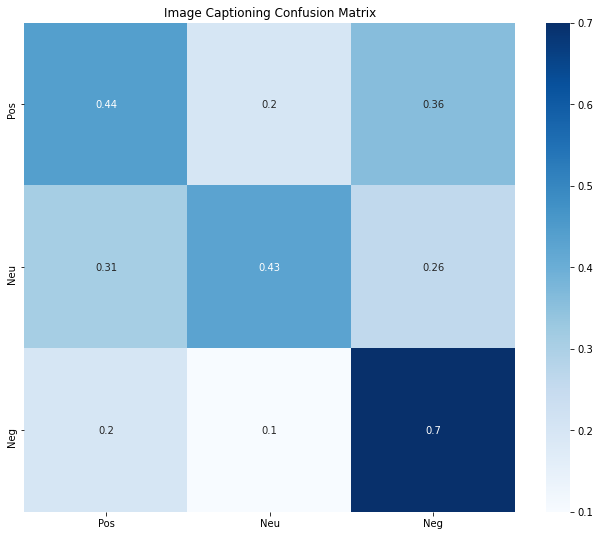

In [124]:
from sklearn import metrics 
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import tensorflow

actual_labels_final = [int(int2label[x]) - 1 for x in actual_labels]
pred_labels_final = [int(int2label[x]) - 1 for x in pred_labels]

# Note the specific ordering
classes=['Pos', 'Neu', 'Neg'] 
con_mat = tensorflow.math.confusion_matrix(labels=actual_labels_final, predictions=pred_labels_final).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm,
                  index = classes, 
                  columns = classes)

figure = plt.figure(figsize=(11, 9))
plt.title("Image Captioning Confusion Matrix")
sn.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)


In [ ]:
### Remove last classifier head

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

best_model.classification_head = Identity()

In [ ]:
print(best_model)

TransformerWithClfHead(
  (transformer): Transformer(
    (tokens_embeddings): Embedding(28996, 410)
    (position_embeddings): Embedding(256, 410)
    (dropout): Dropout(p=0.05, inplace=False)
    (attentions): ModuleList(
      (0): MultiheadAttention(
        (out_proj): Linear(in_features=410, out_features=410, bias=True)
      )
      (1): MultiheadAttention(
        (out_proj): Linear(in_features=410, out_features=410, bias=True)
      )
      (2): MultiheadAttention(
        (out_proj): Linear(in_features=410, out_features=410, bias=True)
      )
      (3): MultiheadAttention(
        (out_proj): Linear(in_features=410, out_features=410, bias=True)
      )
      (4): MultiheadAttention(
        (out_proj): Linear(in_features=410, out_features=410, bias=True)
      )
      (5): MultiheadAttention(
        (out_proj): Linear(in_features=410, out_features=410, bias=True)
      )
      (6): MultiheadAttention(
        (out_proj): Linear(in_features=410, out_features=410, bias=True)


In [ ]:
int2label

{0: '2', 1: '3', 2: '1'}

In [ ]:
### Create the embeddings for the val


valid_dl_eval = create_dataloader(df_val, processor, 
                             batch_size=finetuning_config.batch_size, 
                             valid_pct=None,
                             shuffle=False)

pred_labels = torch.zeros((len(df_val), 410))


i = 0
for batch in valid_dl_eval:
    actual_labels.extend(batch[1].tolist())
    
    best_model.eval()
    with torch.no_grad():
        batch, labels = (t.to(finetuning_config.device) for t in batch)
        inputs = batch.transpose(0, 1).contiguous()
        logits = best_model(inputs,
                        clf_tokens_mask = (inputs == tokenizer.vocab[processor.CLS]),
                        padding_mask = (batch == tokenizer.vocab[processor.PAD]))
        begin_index = i * 32
        end_index = begin_index + len(labels)
        pred_labels[begin_index:end_index, :] = logits
    i += 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [ ]:
pred_labels.shape

torch.Size([766, 410])

In [ ]:
val_output = {
    "embedding": pred_labels.numpy(),
    "vid_names": df_val["vid_name"].tolist()
}

In [ ]:
import pickle
with open("transformer_val_embeddings.pkl", "wb") as f:
    pickle.dump(val_output, f)

In [ ]:
!ls -lh

total 13M
drwx------ 5 root root 4.0K Jun 19 03:04 drive
drwxr-xr-x 3 root root 4.0K Jun 19 04:10 logs
drwxr-xr-x 1 root root 4.0K Jun 17 16:18 sample_data
-rw------- 1 root root 9.2M Jun 19 03:04 train_captions_pretrained_v1.pkl
-rw-r--r-- 1 root root 1.3M Jun 19 04:36 transformer_train_processed.pkl
-rw------- 1 root root 2.6M Jun 19 03:04 val_captions_pretrained_v1.pkl


In [ ]:
### Create the embeddings for the train


train_dl_eval = create_dataloader(df_train, processor, 
                             batch_size=finetuning_config.batch_size, 
                             valid_pct=None,
                             shuffle=False)

pred_labels = torch.zeros((len(df_train), 410))


i = 0
for batch in train_dl_eval:
    actual_labels.extend(batch[1].tolist())
    
    best_model.eval()
    with torch.no_grad():
        batch, labels = (t.to(finetuning_config.device) for t in batch)
        inputs = batch.transpose(0, 1).contiguous()
        logits = best_model(inputs,
                        clf_tokens_mask = (inputs == tokenizer.vocab[processor.CLS]),
                        padding_mask = (batch == tokenizer.vocab[processor.PAD]))
        begin_index = i * 32
        end_index = begin_index + len(labels)
        pred_labels[begin_index:end_index, :] = logits
    i += 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [ ]:
pred_labels.shape

torch.Size([2661, 410])

In [ ]:
train_output = {
    "embedding": pred_labels.numpy(),
    "vid_names": df_train["vid_name"].tolist()
}

In [ ]:
import pickle
with open("transformer_train_embeddings.pkl", "wb") as f:
    pickle.dump(train_output, f)

In [ ]:
!ls -lh

total 18M
drwx------ 5 root root 4.0K Jun 19 03:04 drive
drwxr-xr-x 3 root root 4.0K Jun 19 04:10 logs
drwxr-xr-x 1 root root 4.0K Jun 17 16:18 sample_data
-rw------- 1 root root 9.2M Jun 19 03:04 train_captions_pretrained_v1.pkl
-rw-r--r-- 1 root root 4.2M Jun 19 04:38 transformer_train_embeddings.pkl
-rw-r--r-- 1 root root 1.3M Jun 19 04:36 transformer_val_embeddings.pkl
-rw------- 1 root root 2.6M Jun 19 03:04 val_captions_pretrained_v1.pkl


In [ ]:
!cp transformer_train_embeddings.pkl drive/'My Drive'/cs231n-project/
!cp transformer_val_embeddings.pkl drive/'My Drive'/cs231n-project/